In [2]:
# All necessary imports for this notebook
# You can see them in the requirements.txt

# for data processing
import math
import pandas as pd
import geohash

# for visualization
import folium
from folium import plugins

%matplotlib inline
import matplotlib.pyplot as plt

In [126]:
# NOTE: You have to reference the CSV's from the Air Tube data set in 0. Data

# Load Air Tube Data into a Data Frame
# You can also concatenate them
df = pd.DataFrame(pd.read_csv('data_bg_2017.csv'))

In [127]:
# Extract longitude from geohash
def get_longitude(ghash):
    try:
        return geohash.decode(ghash)[0]
    except ValueError as e:
        print("value: {}, error: {}".format(ghash, e))
        return -1
    except TypeError as e:
        print("value: {}, error: {}".format(ghash, e))
        return -1

# Extract lattitude from geohash
def get_lattitude(ghash):
    try:
        return geohash.decode(ghash)[1]
    except ValueError as e:
        print("geohash: {}, error: {}".format(ghash, e))
        return -1
    except TypeError as e:
        print("geohash: {}, error: {}".format(ghash, e))
        return -1

# Assign longitude and lattitude
df['longitude'] = df['geohash'].apply(get_longitude)
df['latitude'] = df['geohash'].apply(get_lattitude)

value: m-2105171, error: geohash code is [0123456789bcdefghjkmnpqrstuvwxyz]+
geohash: m-2105171, error: geohash code is [0123456789bcdefghjkmnpqrstuvwxyz]+


In [128]:
# Remove rows with an invalid geohash

df = df[(df['longitude'] != -1) & (df['latitude'] != -1)]

In [129]:
# Filter data only for Sofia

def distance(x1, x2, y1, y2):
    return math.sqrt((y1 - x1) ** 2 + (y2 - x2) ** 2)

sofia_center = [42.697708, 23.321867]
german_village = [42.609620, 23.410710]
sofia_radius = distance(*sofia_center, *german_village)

df['in_sofia'] = df[['longitude', 'latitude']].apply(
    lambda point: 1 if distance(*point, *sofia_center) < sofia_radius else 0, axis=1
)

# unique_geohashes = df['geohash'].unique()

# Save to CSV
# df[df.in_sofia == 1][['geohash', 'longitude', 'latitude']].to_csv('geohash_mapping_sofia_2017.csv', index=False)

sofia_df = df[df.in_sofia == 1]

sofia_df.head()

,time,geohash,P1,P2,temperature,humidity,pressure,longitude,latitude,in_sofia
0,2017-09-06T20:00:00Z,sx8d5r7wmxr,9,8,14,55,0,42.580,23.351000,1
1,2017-09-06T20:00:00Z,sx8d6zjg5h8,9,8,0,0,0,42.622,23.332000,1
6,2017-09-06T20:00:00Z,sx8dem6pp1h,15,11,14,54,94841,42.657,23.349000,1
9,2017-09-06T20:00:00Z,sx8devjgkk2,14,13,18,10,0,42.655,23.375999,1
12,2017-09-06T20:00:00Z,sx8d9g29ns5,0,0,17,55,93535,42.645,23.281000,1


In [130]:
sofia_df.describe()

,P1,P2,temperature,humidity,pressure,longitude,latitude,in_sofia
count,419642.000000,419642.000000,419642.000000,419642.000000,419642.000000,419642.000000,419642.000000,419642.0
mean,43.176872,23.397098,8.939606,61.674442,81517.876693,42.678531,23.323406,1.0
std,78.353541,39.862942,12.704712,22.505932,33257.032365,0.029506,0.041544,0.0
min,0.000000,0.000000,-148.000000,0.000000,0.000000,42.580000,23.229000,1.0
25%,10.000000,7.000000,4.000000,50.000000,93982.000000,42.661000,23.291000,1.0
50%,22.000000,13.000000,9.000000,66.000000,94915.000000,42.680000,23.323999,1.0
75%,45.000000,26.000000,14.000000,78.000000,95513.000000,42.694000,23.355000,1.0
max,2000.000000,1000.000000,63.000000,100.000000,162962.000000,42.804000,23.419001,1.0


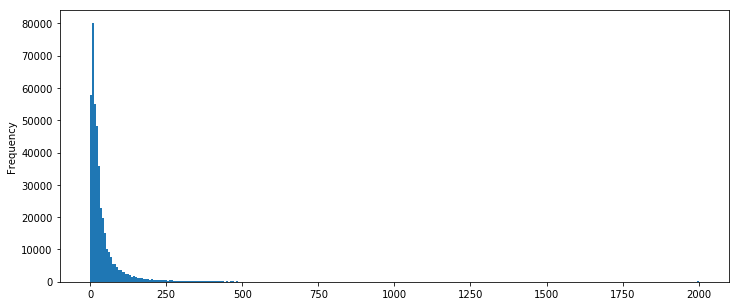

In [131]:
sofia_df.P1.plot.hist(bins=300, figsize=(12, 5))

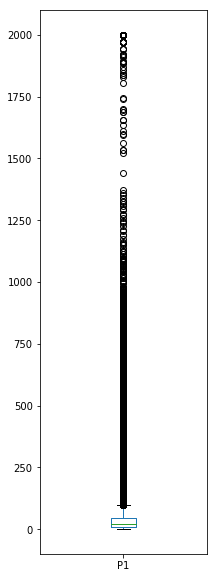

In [132]:
sofia_df.P1.plot.box(figsize=(3, 10))

In [99]:
def make_heatmap(df, timestamp, metric):
    points = df[df.time == timestamp]

    folium_map = folium.Map(location=sofia_center,
                            zoom_start=11,
                            tiles='Stamen Terrain')

    for i in range(0, len(points)):
        point = points.iloc[i]
        
        folium.Circle(
            radius=10,
            location=[point['longitude'], point['latitude']],
            popup=str(point['P1']),
            color='#333333',
            fill=False
        ).add_to(folium_map)

    # plot heatmap
    folium_map.add_child(plugins.HeatMap(
        points[['longitude', 'latitude', metric]].as_matrix(),
        min_opacity=0.2,
        max_val=points[metric].max(),
        radius=30, blur=17,
        max_zoom=1
    ))

    # You can also save the interactive heat map as an HTML file
    # folium_map.save("output-map.html")
    return folium_map

In [160]:
make_heatmap(sofia_df, '2017-09-06T20:00:00Z', 'P1')

In [161]:
make_heatmap(sofia_df, '2017-09-06T20:00:00Z', 'P2')

In [145]:
# Normalize P1
sofia_df = sofia_df.assign(P1_normalized=pd.Series((sofia_df.P1 - sofia_df.P1.mean()) / sofia_df.P1.std()))

In [149]:
# Add column in which PM10 above the allowed threshold is more than 1 and
# PM10 below that threshold is less than 1

pm10_threshold = 50
sofia_df = sofia_df.assign(P1_above_threshold=pd.Series(sofia_df.P1 / pm10_threshold))

In [155]:
def make_time_series_heatmap(df, metric, radius, take = None):
    """Create a Time Series Heat Map.
    
    The map is interactive and

    Keyword arguments:
    df     -- the data frame with time, longitude, lattitude and the chosen metric
    metric -- the imaginary part 
    radius -- the radius of the heat in the visualization
    take   -- an integer, denoting how many time points should be taken
              By default it is None, denoting that all time points will be visualized.
    """
    
    folium_map = folium.Map(location=sofia_center,
                            zoom_start=11.5,
                            tiles='Stamen Terrain')

    time_index = sorted(df.time.unique())
    time_index = time_index[0:take] if take else time_index
    print("Visualizing time series heat map with {} time points...".format(len(time_index)))

    map_data = [None] * len(time_index)

    for index, timestamp in enumerate(time_index):
        map_data[index] = df[df.time == timestamp][['longitude', 'latitude', metric]].values.tolist()

    heat_map = plugins.HeatMapWithTime(
        map_data,
        index=time_index,
        auto_play=True,
        radius=radius,
        max_speed=60
    )

    heat_map.add_to(folium_map)

    # You can also save the interactive heat map as an HTML file
    # This is necessary for very large data set visualizations
    folium_map.save("heatmap-timeseries.html")
    
    return folium_map

In [157]:
make_time_series_heatmap(
    df=sofia_df,
    metric='P1_above_threshold',
    radius=sofia_df.P1.mean(),
    take=100  # The heatmap gets too big to be visualized inline in the notebook
)

Visualizing time series heat map with 100 time points...
